# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [23]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 5000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [24]:
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [25]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.weights = tf.Variable(tf.random.normal([in_features, out_features]))
        self.bias = tf.Variable(tf.zeros([out_features]))

    def __call__(self, x):
        z = tf.matmul(x, self.weights) + self.bias
        return tf.nn.relu(z)  # Використовуйте ReLU або іншу функцію активації за вибором


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.out_layer(x)
    return tf.nn.softmax(x)

In [26]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати етикетку в один гарячий вектор.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення кліпу, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівнюємо передбачені значення з істинними мітками
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Обчислюємо середню точність з використанням згортання
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = nn.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [28]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        acc = accuracy(pred, batch_y)
        print(f"Шаг: {step}, Функція втрат: {loss}, Точність: {acc}")

        # Зберігаємо значення функції втрат та точності
        loss_history.append(loss)
        accuracy_history.append(acc)

print("Тренування завершено!")

Шаг: 100, Функція втрат: 4704.1806640625, Точність: 0.11328125
Шаг: 200, Функція втрат: 3875.25048828125, Точність: 0.26953125
Шаг: 300, Функція втрат: 3792.534912109375, Точність: 0.28515625
Шаг: 400, Функція втрат: 3849.83056640625, Точність: 0.3046875
Шаг: 500, Функція втрат: 3647.29443359375, Точність: 0.3125
Шаг: 600, Функція втрат: 3087.766357421875, Точність: 0.41796875
Шаг: 700, Функція втрат: 2921.98046875, Точність: 0.44921875
Шаг: 800, Функція втрат: 3191.382568359375, Точність: 0.3984375
Шаг: 900, Функція втрат: 3315.72216796875, Точність: 0.375
Шаг: 1000, Функція втрат: 2942.70361328125, Точність: 0.4453125
Шаг: 1100, Функція втрат: 2582.115234375, Точність: 0.515625
Шаг: 1200, Функція втрат: 2611.13134765625, Точність: 0.5078125
Шаг: 1300, Функція втрат: 2611.13134765625, Точність: 0.5078125
Шаг: 1400, Функція втрат: 2155.219482421875, Точність: 0.59375
Шаг: 1500, Функція втрат: 2258.835693359375, Точність: 0.57421875
Шаг: 1600, Функція втрат: 2155.219482421875, Точність:

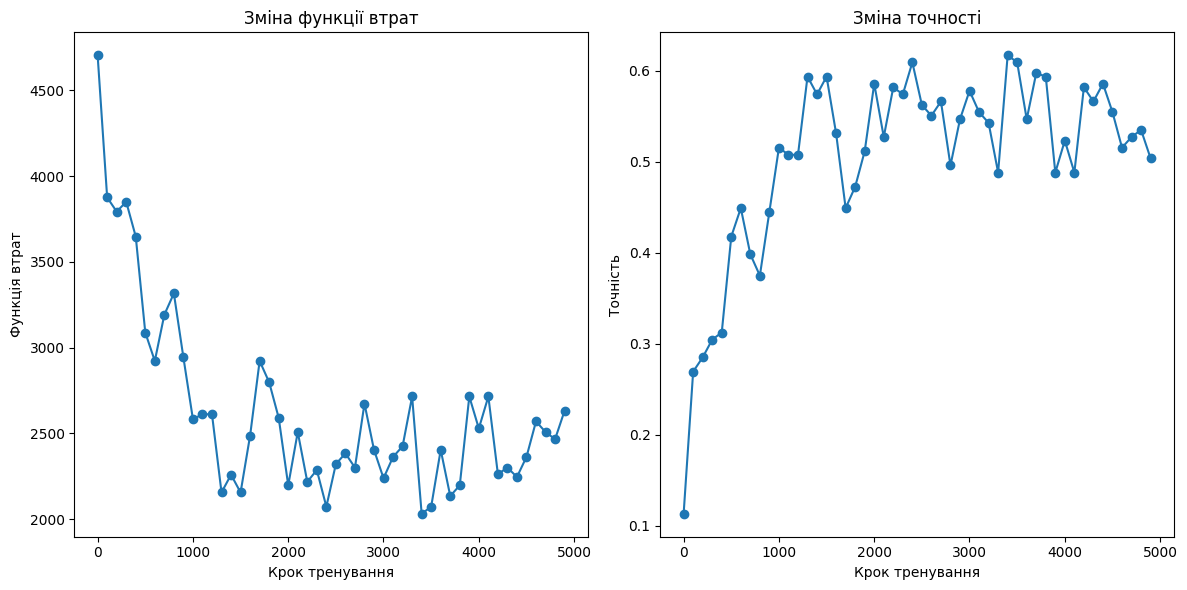

In [29]:
# Виведи графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Зміна функції втрат')
plt.xlabel('Крок тренування')
plt.ylabel('Функція втрат')

# Виведення графіка точності
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Зміна точності')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')

plt.tight_layout()
plt.show()


In [30]:
# Обчисли точність навченої нейромережі

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Точність на тестових даних: {test_acc.numpy()}")


Точність на тестових даних: 0.5738999843597412


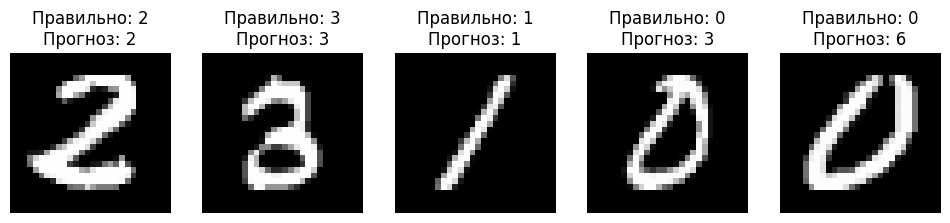

Точність на цих 5 зображеннях: 60.00%


In [31]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьми 5
# випадкових зображень і передай їх у нейронну мережу.
# Виведи зображення та випиши поруч відповідь нейромережі.
# Зроби висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

# Виберемо 5 випадкових зображень з тестової вибірки
random_indices = random.sample(range(len(x_test)), 5)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Прогнозуємо класи для вибраних зображень
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виведемо зображення та випишемо поруч відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Правильно: {test_labels[i]}\nПрогноз: {predicted_labels[i]}")
    plt.axis('off')

plt.show()

# Порівняємо прогнози з правильними мітками та обчислимо точність
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Точність на цих 5 зображеннях: {accuracy * 100:.2f}%")


На основі результатів тренування та тестування можна робити висновки про якість навченої мережі, її ефективність у вирішенні завдання розпізнавання рукописних цифр та можливі шляхи подальшого вдосконалення.